## Objectif du projet
L'objectif de ce projet est de résumer des sections de textes légaux à partir d'un modèle d'IA pré-entrainé.


## Données

Dataset open source de 446 sections de texte avec résumés


## Étapes du Notebook


1.   Installation et chargement des librairies
2.   Chargement, nettoyage et pré-processing des données
4.   Entrainement et sauvegarde du modèle

## 1.  Installation et chargement des librairies

!pip install json
!pip install pandas
!pip install sklearn
!pip install matplotlib
!pip install transformers
!pip install pytorch

In [7]:
import json
import pandas as pd
from sklearn.model_selection import train_test_split
import re
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from torch.utils.data import Dataset

C:\Users\vital.guinguinni\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 2. Chargement, nettoyage et pre-processing des données

In [8]:
# Chemins vers le jeu de données
open_source_path = '../data'
import os

filenames = [open_source_path + "/" + file for file in os.listdir(open_source_path) 
             if file.startswith("train_set_") and file.endswith(".json")]
filenames

['../data/train_set_helicopters.json', '../data/train_set_open_dataset.json']

In [11]:
# Fonction pour charger et formatter les données depuis un fichier JSON
def load_and_format_data(file_path):
    """Loads and formats data from a given JSON file into a list of dictionaries,
    where each dictionary represents an item with its unique ID and associated data."""
    with open(file_path, 'r') as file:
        data = json.load(file)
        formatted_data = [{'uid': key, **value} for key, value in data.items()]
    return formatted_data

# Fonction pour nettoyer les textes
def clean_text(text):
    """Cleans the given text by removing HTML tags, non-alphabetic characters,
    and extra spaces, then returns the cleaned text."""
    text = re.sub(r'<[^>]+>', '', text)  # Remove HTML tags
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove non-alphabetic characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

In [15]:
# Chargement et formattage du jeu de données
df_helicopters = load_and_format_data(filenames[0]) 
df_helicopters = load_and_format_data(filenames[0])

# Conversion en Dataframe pour faciliter la manipulation
open_source_df_1 = pd.DataFrame(df_helicopters)
open_source_df_1

,uid,original_text,reference_summary
0,train_sum01,These general Standard Conditions of Sale appl...,These terms and conditions apply as soon as th...
1,train_sum010,Each Party represents to the other as at the d...,Each Party represents that the other is not a ...
2,train_sum0100,"All living, travelling and accommodation expen...","Expenses relating to the travelling, living an..."
3,train_sum0101,"Unless otherwise specified in the Contract, th...","Unless otherwise specified in the Contract, th..."
4,train_sum0102,Reasonable insurance coverage of risks arising...,Reasonable insurance coverage of risks arising...
...,...,...,...
408,train_sum095,No term or provision hereof will be considered...,"No term, provision or breach shall be waived o..."
409,train_sum096,Any variation or modification of the Contract ...,Any modification to the contract shall be put ...
410,train_sum097,The relationship between the Parties is solely...,No joint venture or partnership is intended no...
411,train_sum098,"The Customer shall not be entitled, without th...",Unless the Seller agrees to it through writing...


In [25]:
# Chargement et formattage du jeu de données
df_open = load_and_format_data(filenames[1]) 
df_open = load_and_format_data(filenames[1])

# Conversion en Dataframe pour faciliter la manipulation
open_source_df_2 = pd.DataFrame(df_open)[['uid','original_text','reference_summary']]
#open_source_df_2

In [32]:
open_source_df = pd.concat([open_source_df_1, open_source_df_2])
#open_source_df
open_source_df["len_original"] = open_source_df['original_text'].apply(lambda x : len(x))
open_source_df["len_sum"] = open_source_df["reference_summary"].apply(lambda x : len(x))
open_source_df['ratio'] = open_source_df["len_sum"] / open_source_df["len_original"]
open_source_df

,uid,original_text,reference_summary,len_original,len_sum,ratio
0,train_sum01,These general Standard Conditions of Sale appl...,These terms and conditions apply as soon as th...,321,161,0.501558
1,train_sum010,Each Party represents to the other as at the d...,Each Party represents that the other is not a ...,788,150,0.190355
2,train_sum0100,"All living, travelling and accommodation expen...","Expenses relating to the travelling, living an...",108,108,1.000000
3,train_sum0101,"Unless otherwise specified in the Contract, th...","Unless otherwise specified in the Contract, th...",254,164,0.645669
4,train_sum0102,Reasonable insurance coverage of risks arising...,Reasonable insurance coverage of risks arising...,195,179,0.917949
...,...,...,...,...,...,...
441,tosdr417,third party vendors including google use cooki...,this service allows tracking via third party c...,278,97,0.348921
442,tosdr418,the third parties that display advertisements ...,this service employs third party cookies but w...,675,71,0.105185
443,tosdr419,we may make use of third party service provide...,third parties may be involved in operating the...,452,55,0.121681
444,tosdr420,please be aware that we may transfer your info...,your data may be processed and stored anywhere...,248,60,0.241935


In [45]:
open_source_df = open_source_df[open_source_df['ratio']>0.05]
open_source_df = open_source_df[open_source_df['ratio']<1]
len(open_source_df)

809

In [46]:
# Nettoyage des textes
open_source_df['original_text_clean'] = open_source_df['original_text'].apply(clean_text)
open_source_df['reference_summary_clean'] = open_source_df['reference_summary'].apply(clean_text)

In [47]:
# Analyse de la longeur des textes originaux et des résumés associés
original_text_lengths = open_source_df['original_text_clean'].apply(len)
summary_lengths = open_source_df['reference_summary_clean'].apply(len)

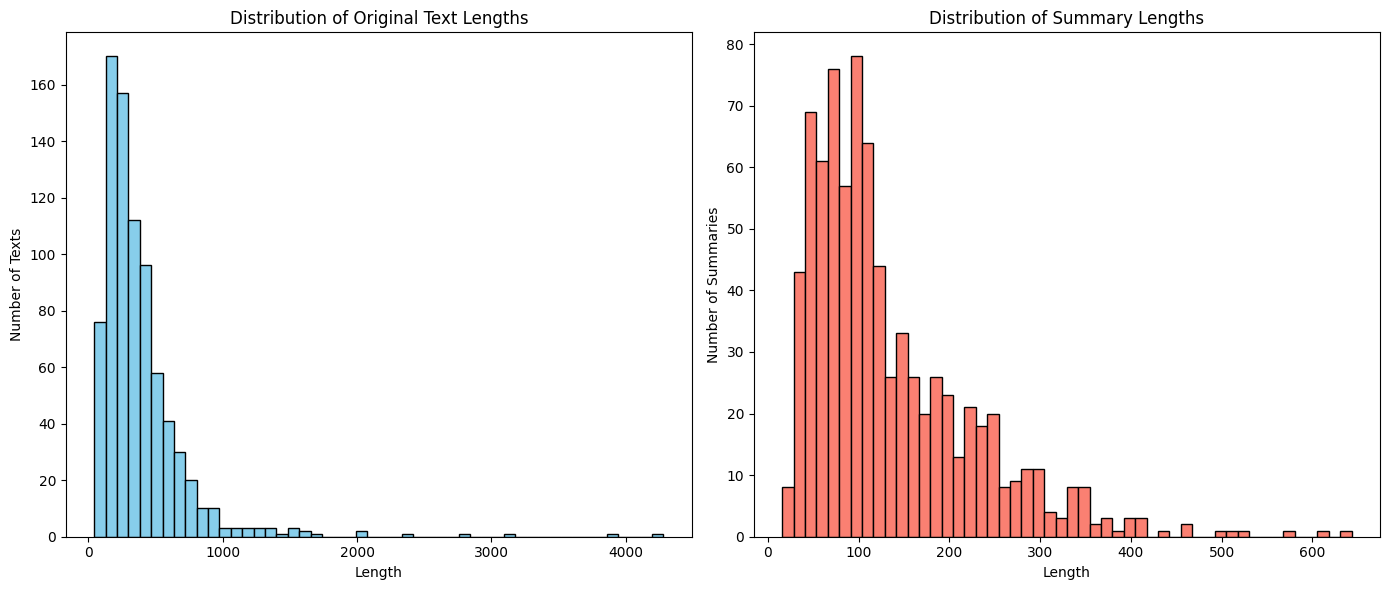

In [48]:
# Création de graphique pour la distribution des longueurs de textes
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(original_text_lengths, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Original Text Lengths')
plt.xlabel('Length')
plt.ylabel('Number of Texts')

plt.subplot(1, 2, 2)
plt.hist(summary_lengths, bins=50, color='salmon', edgecolor='black')
plt.title('Distribution of Summary Lengths')
plt.xlabel('Length')
plt.ylabel('Number of Summaries')

plt.tight_layout()
plt.show()